# Predicción del Precio del Oro

Momento de Retroalimentación M5. Estadística Avanzada



```
# Abraham Gil Félix | A01750884
```



 Dataset: https://www.gold.org/goldhub/data/gold-prices
 
El conjunto de datos proporciona el precio del oro en una variedad de marcos de tiempo (diario, semanal, mensual, anual) desde 1978, y en las principales monedas comerciales, de producción y de consumo.

In [62]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [63]:
!pip install tbats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importación de librerías

In [117]:
import pandas as pd
import numpy as np
from numpy import log
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from datetime import datetime
from math import sqrt

from pmdarima import auto_arima
from pmdarima.preprocessing import FourierFeaturizer

from statsmodels.tsa.api import SARIMAX
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, arma_order_select_ic
from tbats import TBATS, BATS

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

## Carga de los datos

In [65]:
data = pd.read_excel('/content/drive/MyDrive/7MO SEMESTRE/Inteligencia Artificial Avanzada para la Ciencia de Datos II/M5. Estadística Avanzada para la Ciencia de Datos/Prices.xlsx', sheet_name='Daily')
data.head()

,Name,US dollar,Euro,Japanese yen,Pound sterling,Canadian dollar,Swiss franc,Indian rupee,Chinese renmimbi,US dollar.1,...,Vietnamese dong,Egyptian pound,Korean won,Euro.1,Russian ruble,US dollar.2,South African rand,Chinese renmimbi.1,Canadian dollar.1,Australian dollar
0,1978-12-29,226.00,137.06,NaN,110.70,NaN,NaN,NaN,NaN,226.00,...,NaN,NaN,NaN,137.06,NaN,226.00,NaN,NaN,NaN,NaN
1,1979-01-01,226.00,137.06,NaN,110.70,NaN,NaN,NaN,NaN,226.00,...,NaN,NaN,NaN,137.06,NaN,226.00,NaN,NaN,NaN,NaN
2,1979-01-02,226.80,137.29,43164.91,111.45,263.74,359.62,1792.85,NaN,226.80,...,NaN,NaN,107470.04,137.29,NaN,226.80,194.56,NaN,263.74,193.61
3,1979-01-03,218.60,134.01,43717.90,107.98,264.39,365.87,1802.15,NaN,218.60,...,NaN,NaN,108027.43,134.01,NaN,218.60,192.23,NaN,264.39,192.97
4,1979-01-04,223.15,136.79,43674.89,110.66,264.14,366.38,1811.74,NaN,223.15,...,NaN,NaN,108602.47,136.79,NaN,223.15,193.01,NaN,264.14,194.55


In [66]:
data_gold = data[['Name', 'US dollar']]
data_gold.set_index('Name', inplace=True)
data_gold.dropna()

,US dollar
Name,
1978-12-29,226.00
1979-01-01,226.00
1979-01-02,226.80
1979-01-03,218.60
1979-01-04,223.15
...,...
2022-10-17,1664.75
2022-10-18,1653.00
2022-10-19,1631.70


## Partición de los datos

In [67]:
y = data_gold['US dollar']
y_to_train = y.iloc[:(len(y)-1431)] 
y_to_test = y.iloc[(len(y)-1431):] # last 4 years for testing - 1431 rows

## Exploración de los datos

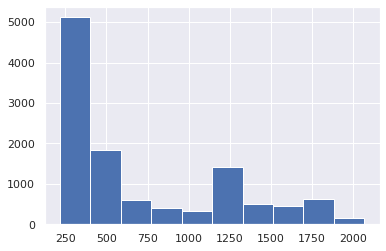

5.379205870281376 7.633926125989263


In [68]:
data_gold['US dollar'].hist()
plt.show()
log_transform = log(data_gold['US dollar'])
print(min(log_transform), max(log_transform))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


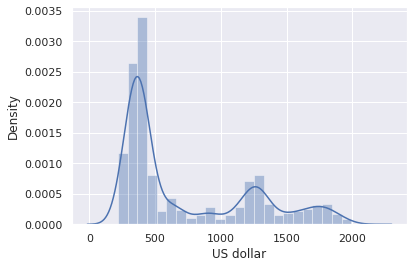

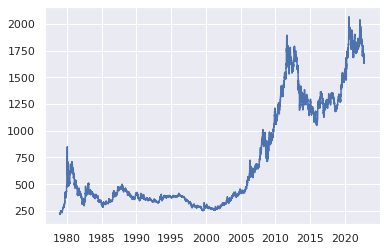

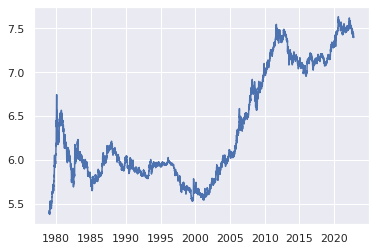

In [69]:
# Show non stationary
sns.set()
sns.distplot(data_gold['US dollar'])
plt.show()

plt.plot(data_gold.index, data_gold['US dollar'])
plt.show()

plt.plot(data_gold.index, log_transform)
plt.show()

## Métricas Mejor Modelo

### Aikake Information Criterion (AIC) - Bayesian Information Criterion (BIC)

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


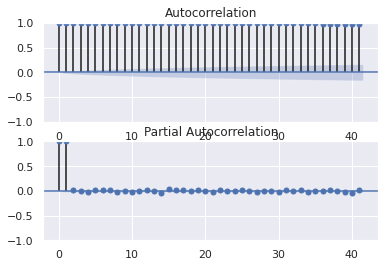

In [70]:
# ACF and PACF plots
series = data_gold['US dollar']
plt.figure()
plt.subplot(211)
plot_acf(series, ax=plt.gca())
plt.subplot(212)
plot_pacf(series, ax=plt.gca())
plt.show()

### Serie No Estacional

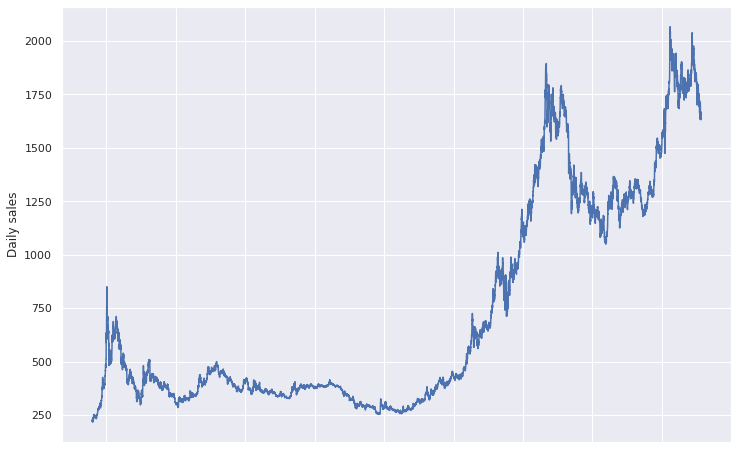

In [71]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(data_gold.index, data_gold['US dollar'])
plt.ylabel('Daily sales')
every_nth = 60
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

plt.show()

### Serie Estacional

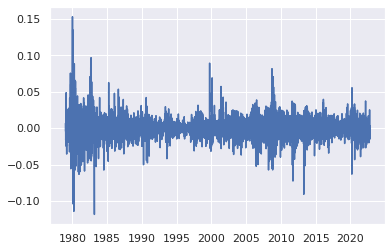

In [72]:
tslog = np.log(data_gold['US dollar'])
rollavg = tslog.rolling(5).mean()
tslogdiff = tslog - rollavg
tslogdiff.dropna(inplace = True)
plt.plot(tslogdiff)
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


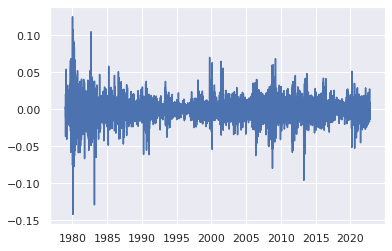

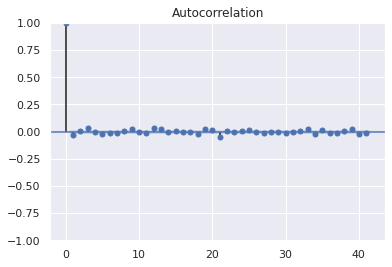

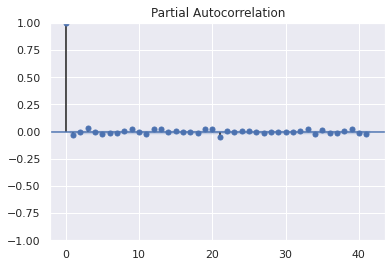

In [73]:
logret= diff(tslog)
plt.plot(logret)
plot_acf(logret)
plot_pacf(logret)
plt.show()

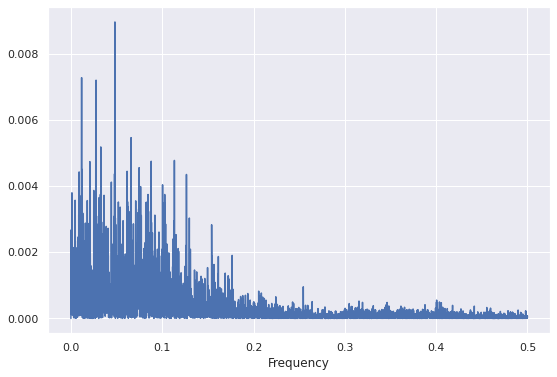

In [74]:
f, Pxx = signal.periodogram(tslogdiff)
fig, ax = plt.subplots(figsize=(9,6))
plt.plot(f, Pxx)
plt.xlabel('Frequency')
plt.show()

## ARIMA Model

In [75]:
arima_model = auto_arima(y_to_train, seasonal=True, trace=True, error_action='raise')

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=72180.396, Time=25.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=72223.399, Time=0.45 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=72221.712, Time=0.61 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=72221.544, Time=0.96 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=72222.739, Time=0.42 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=72216.128, Time=5.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=72216.163, Time=7.59 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=72219.544, Time=3.84 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=72219.554, Time=7.41 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=72221.977, Time=5.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=72217.616, Time=7.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=72217.631, Time=5.06 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=18.33 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=72179.670, Time=4.42 sec
 ARIMA(1,1,2)(0,0,0)[0]

### SARIMAX

In [76]:
model = SARIMAX(y_to_train, order=(2, 1, 2), seasonal_order=(0,0,0,0))
res = model.fit()
res.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              US dollar   No. Observations:                10000
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -36084.835
Date:                Thu, 27 Oct 2022   AIC                          72179.670
Time:                        23:30:10   BIC                          72215.721
Sample:                    12-29-1978   HQIC                         72191.873
                         - 04-27-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5966      0.008    -72.813      0.000      -0.613      -0.581
ar.L2         -0.9485      0.008   -120.167      0.000      -0.964      -0.933
ma.L1          0.5745      0.008     68.670      0.000       0.558       0.591
ma.L2          0.9462      0.008    117.079      0.000       0.930       0.962
sigma2        79.8241      0.319    250.186      0.000      79.199      80.449
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):            225498.89
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               3.04   Skew:                            -0.77
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

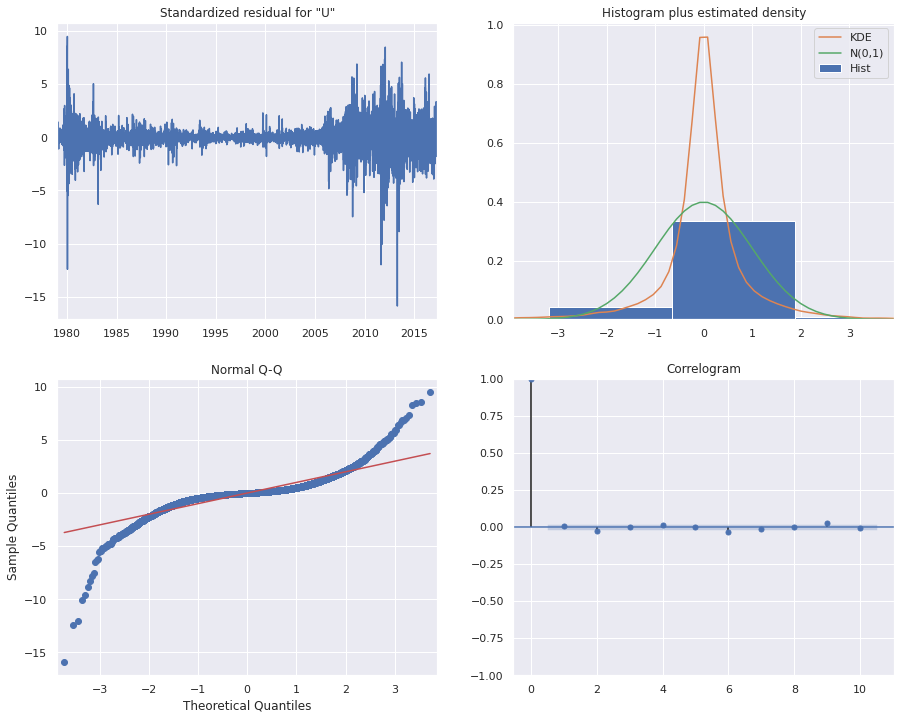

In [77]:
res.plot_diagnostics(figsize=(15, 12))
plt.show()

In [78]:
forecast = res.predict(start=(len(y)-1431), end=len(y))
preds = res.predict(start=0, end=(len(y)-1431))

### Predicciones

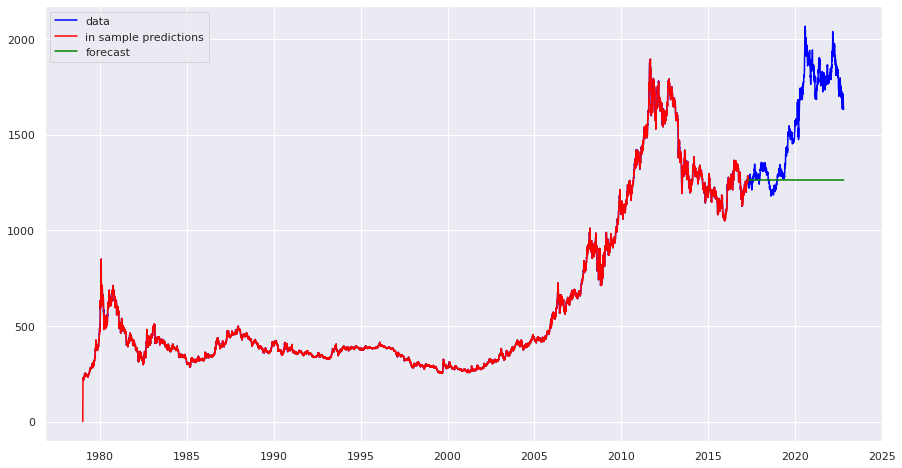

In [79]:
x_axis = np.arange(0, len(y)-1431, 1)

fig,ax = plt.subplots(figsize=(15,8))
ax.plot(data_gold.index, data_gold['US dollar'], label='data',color='blue')
ax.plot(preds, label='in sample predictions', color='red')
ax.plot(forecast, label='forecast', color='green')
plt.legend()
plt.show()

## ARIMA with external regressors

In [80]:
data_gold = data_gold.reset_index()

In [81]:
data_gold = data_gold.set_index('Name')
y = data_gold['US dollar']
y_to_train = y.iloc[:(len(y)-1431)]
y_to_test = y.iloc[(len(y)-1431):] 

In [82]:
# Prepare Fourier terms
exog = pd.DataFrame({'date': y.index})
exog = exog.set_index(pd.PeriodIndex(exog['date'], freq='D'))
exog['sin365'] = np.sin(2 * np.pi * exog.index.dayofyear / 365.25)
exog['cos365'] = np.cos(2 * np.pi * exog.index.dayofyear / 365.25)
exog['sin365_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 365.25)
exog['cos365_2'] = np.cos(4 * np.pi * exog.index.dayofyear / 365.25)
exog = exog.drop(columns=['date'])
exog_to_train = exog.iloc[:(len(y)-1431)]
exog_to_test = exog.iloc[(len(y)-1431):]

In [83]:
exog_to_train

,sin365,cos365,sin365_2,cos365_2
date,,,,
1978-12-29,-0.038696,0.999251,-0.077334,0.997005
1979-01-01,0.017202,0.999852,0.034398,0.999408
1979-01-02,0.034398,0.999408,0.068755,0.997634
1979-01-03,0.051584,0.998669,0.103031,0.994678
1979-01-04,0.068755,0.997634,0.137185,0.990545
...,...,...,...,...
2017-04-21,0.943196,-0.332235,-0.626727,-0.779239
2017-04-24,0.924803,-0.380447,-0.703677,-0.710520
2017-04-25,0.918121,-0.396299,-0.727701,-0.685894


In [84]:
exog_to_test

,sin365,cos365,sin365_2,cos365_2
date,,,,
2017-04-28,0.896456,-0.443132,-0.794497,-0.607268
2017-05-01,0.872404,-0.488785,-0.852837,-0.522178
2017-05-02,0.863867,-0.503720,-0.870294,-0.492533
2017-05-03,0.855075,-0.518505,-0.886721,-0.462305
2017-05-04,0.846029,-0.533137,-0.902099,-0.431530
...,...,...,...,...
2022-10-17,-0.962068,0.272811,-0.524926,-0.851148
2022-10-18,-0.957232,0.289320,-0.553893,-0.832588
2022-10-19,-0.952114,0.305743,-0.582205,-0.813042


In [85]:
four_terms = FourierFeaturizer(365.25, 2)
y_prime, exog2 = four_terms.fit_transform(data_gold['US dollar'])

# Split the time series as well as exogenous features data into train and test splits 
y_to_train = y_prime.iloc[:(len(y)-1431)]
y_to_test =  y_prime.iloc[(len(y)-1431):] 

exog_to_train = exog2.iloc[:(len(y)-1431)]
exog_to_test = exog2.iloc[(len(y)-1431):]

### SARIMAX with external regressors

In [86]:
arima_exog_model = SARIMAX(endog=list(y_to_train), order=(2, 1, 2), seasonal_order=(0,0,0,0), exog=exog_to_train)
res2 = arima_exog_model.fit()
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                10000
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -36083.896
Date:                Thu, 27 Oct 2022   AIC                          72185.792
Time:                        23:30:28   BIC                          72250.684
Sample:                             0   HQIC                         72207.758
                              - 10000                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
FOURIER_S365-0    -1.4613      7.635     -0.191      0.848     -16.426      13.504
FOURIER_C365-0     2.8290      7.200      0.393      0.694     -11.283      16.941
FOURIER_S365-1    -1.5550      3.657     -0.425      0.671      -8.723       5.613
FOURIER_C365-1    -4.4786      3.758     -1.192      0.233     -11.845       2.888
ar.L1             -0.5967      0.008    -72.374      0.000      -0.613      -0.581
ar.L2             -0.9482      0.008   -119.338      0.000      -0.964      -0.933
ma.L1              0.5744      0.008     68.250      0.000       0.558       0.591
ma.L2              0.9459      0.008    116.102      0.000       0.930       0.962
sigma2            79.8071      0.326    244.911      0.000      79.168      80.446
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):            225096.47
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               3.04   Skew:                            -0.77
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

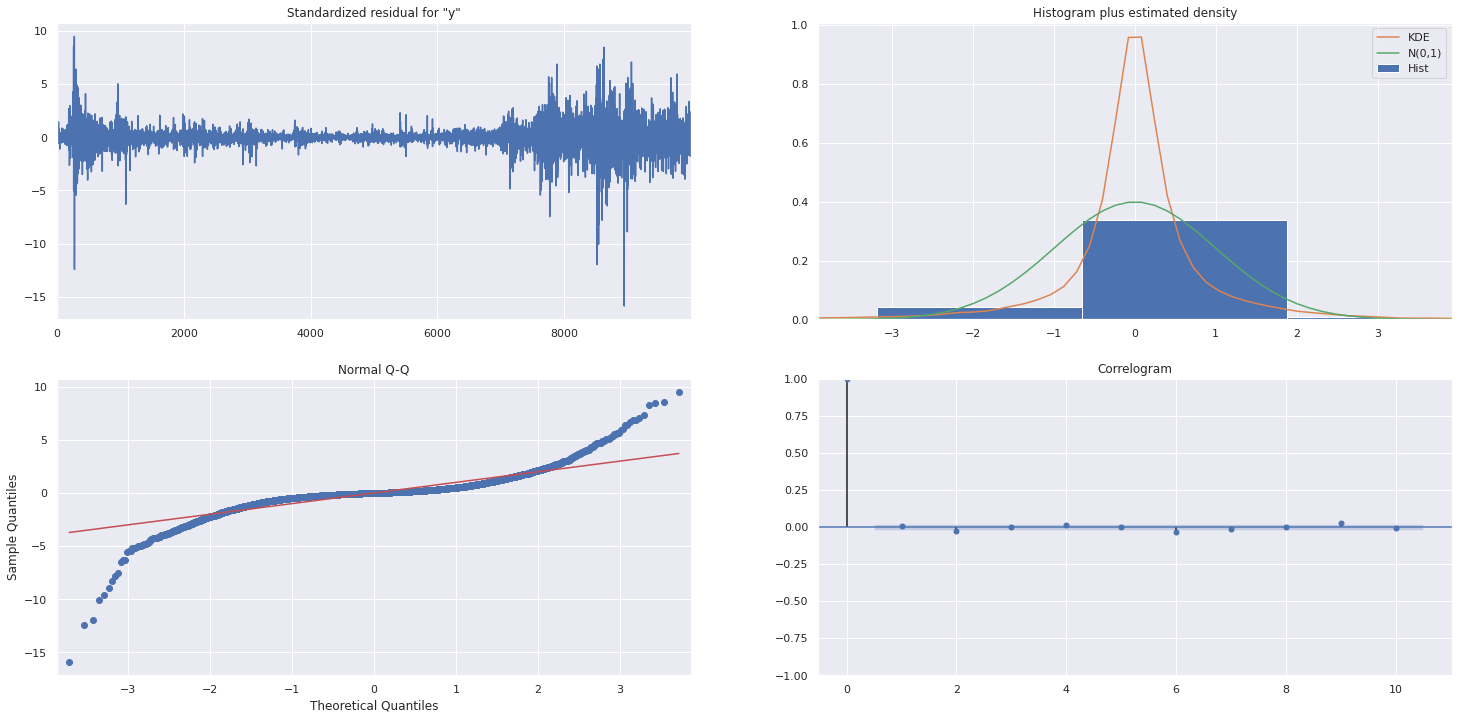

In [87]:
res2.plot_diagnostics(figsize=(25, 12))
plt.show()

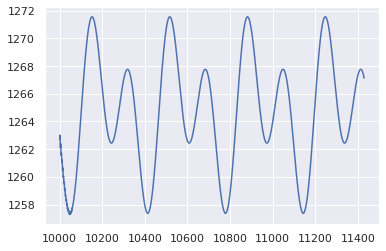

In [88]:
forecast2 = res2.predict(start=(len(y)-1431), end=(len(y)-1), exog=exog_to_test)
plt.plot(forecast2)

In [89]:
data_gold = data_gold.reset_index()
data_gold.Name = pd.to_datetime(data_gold.Name)

In [90]:
data_gold.index

RangeIndex(start=0, stop=11431, step=1)

In [91]:
preds.index = np.arange(0, 10001, 1)
preds.index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
             9991,  9992,  9993,  9994,  9995,  9996,  9997,  9998,  9999,
            10000],
           dtype='int64', length=10001)

In [92]:
forecast2.index

RangeIndex(start=10000, stop=11431, step=1)

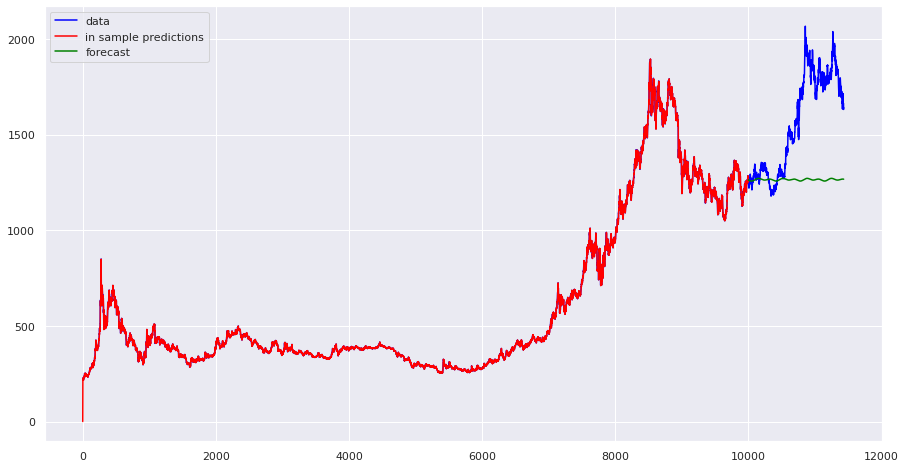

In [93]:
fig,ax = plt.subplots(figsize=(15,8))
ax.plot(data_gold.index, data_gold['US dollar'], label='data', color='blue')
ax.plot(preds.index, preds, label='in sample predictions', color='red')
ax.plot(forecast2.index, forecast2, label='forecast', color='green')
plt.legend()
plt.show()

### Predicciones

In [94]:
pred0 = res.get_prediction(start='2019-01-01', dynamic=False)
pred0_ci = pred0.conf_int()

In [95]:
pred1 = res.get_prediction(start='2019-01-01', dynamic=True)
pred1_ci = pred1.conf_int()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2292: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)


In [96]:
pred2 = res.get_forecast('2023-12-01')
pred2_ci = pred2.conf_int()
print(pred2.predicted_mean['2022-01-01':'2022-10-21'])

2022-01-03    1263.045802
2022-01-04    1263.045802
2022-01-05    1263.045802
2022-01-06    1263.045802
2022-01-07    1263.045802
                 ...     
2022-10-17    1263.045802
2022-10-18    1263.045802
2022-10-19    1263.045802
2022-10-20    1263.045802
2022-10-21    1263.045802
Freq: B, Name: predicted_mean, Length: 210, dtype: float64


In [97]:
pred2_ci

,lower US dollar,upper US dollar
2017-04-28,1245.411542,1280.433869
2017-05-01,1238.860442,1287.844327
2017-05-02,1232.985363,1292.973926
2017-05-03,1228.033820,1297.555150
2017-05-04,1224.459379,1302.057607
...,...,...
2023-11-27,544.402943,1981.688661
2023-11-28,544.193701,1981.897903
2023-11-29,543.984521,1982.107084
2023-11-30,543.775400,1982.316204


In [98]:
data_gold.set_index('Name', inplace=True)

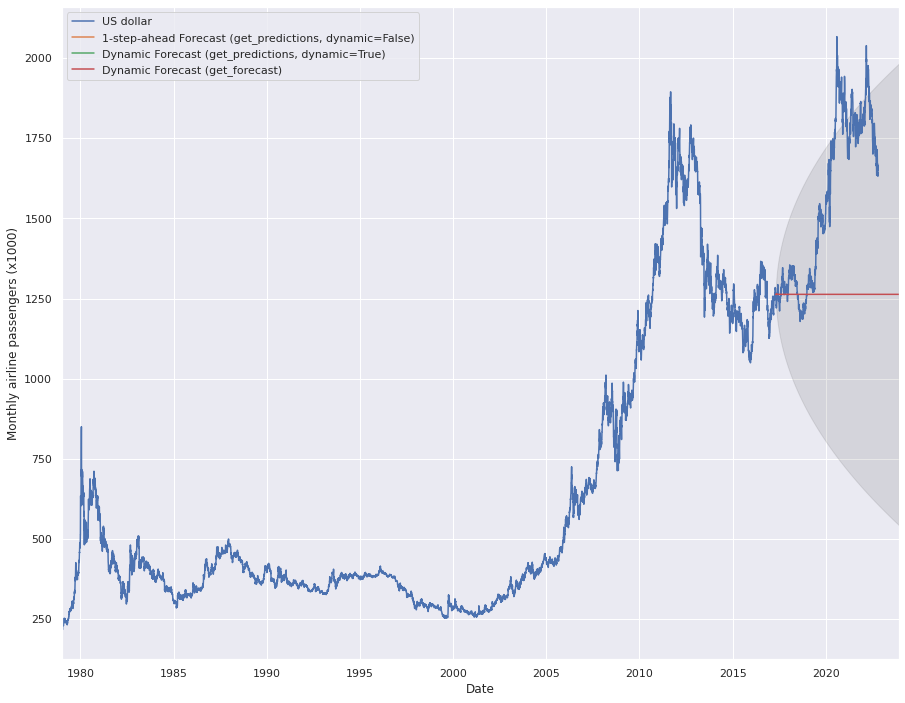

In [99]:
ax = data_gold.plot(figsize=(15, 12))
pred0.predicted_mean.plot(ax=ax, label='1-step-ahead Forecast (get_predictions, dynamic=False)')
pred1.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_predictions, dynamic=True)')
pred2.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_forecast)')
ax.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color='k', alpha=.1)
plt.ylabel('Monthly airline passengers (x1000)')
plt.xlabel('Date')
plt.legend()
plt.show()

## Regresión lineal

In [100]:
# Define exploratory variables
# Finding moving average of past 3 days and 12 days
data_gold['S_1'] = data_gold['US dollar'].shift(1).rolling(window=3).mean()
data_gold['S_2'] = data_gold['US dollar'].shift(1).rolling(window=12).mean()
data_gold = data_gold.dropna()
X = data_gold[['S_1', 'S_2']]
X.head()

,S_1,S_2
Name,,
1979-01-16,218.366667,222.412500
1979-01-17,218.366667,221.966667
1979-01-18,221.583333,222.070833
1979-01-19,226.550000,222.483333
1979-01-22,229.850000,223.479167


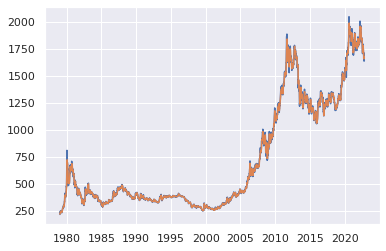

In [101]:
plt.plot(data_gold.index, data_gold['S_1'])
plt.plot(data_gold.index, data_gold["S_2"])
plt.show()

In [102]:
# Dependent variable
y = data_gold['US dollar']
y.head()

Name
1979-01-16    220.65
1979-01-17    227.25
1979-01-18    231.75
1979-01-19    230.55
1979-01-22    235.00
Name: US dollar, dtype: float64

In [103]:
# Split into train and test
t = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t, shuffle=False)

Gold Price = 1.13 * 2 Month Moving Average -0.13 * 1 Month Moving Average + 0.27


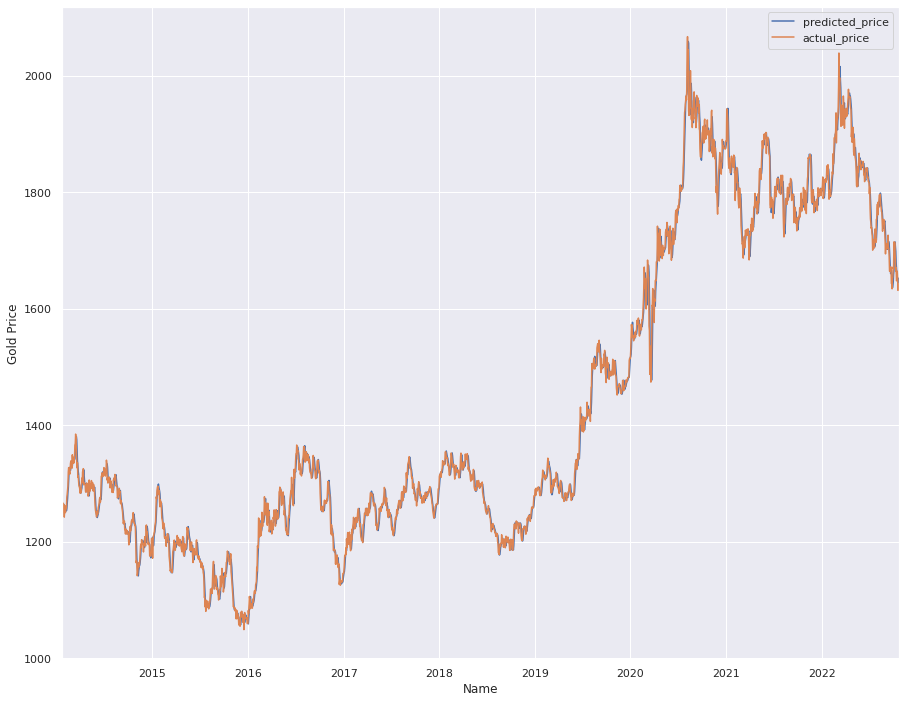

R square for regression 99.62


16.339893096488822

In [104]:
# Performing linear regression
linear = LinearRegression().fit(X_train, y_train)

print("Gold Price =", round(linear.coef_[0], 2), "* 2 Month Moving Average", round(
    linear.coef_[1], 2), "* 1 Month Moving Average +", round(linear.intercept_, 2))

# Predict prices
predicted_price = linear.predict(X_test)

predicted_price = pd.DataFrame(predicted_price, index=y_test.index, columns=['price'])

predicted_price.plot(figsize=(15, 12))
y_test.plot()
plt.legend(['predicted_price', 'actual_price'])
plt.ylabel("Gold Price")
plt.show()

# Calculate R square and rmse to check goodness of fit
r2_score = linear.score(X_test, y_test)*100
print("R square for regression", float("{0:.2f}".format(r2_score)))
sqrt(mean_squared_error(y_test,predicted_price))

In [105]:
# Check stationarity
X = data_gold['US dollar']
split = len(X) // 2
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

result_of_adfuller = adfuller(data_gold['US dollar'])
print('ADF Statistic: %f' % result_of_adfuller[0])
print('p-value: %f' % result_of_adfuller[1])
print('Critical Values:')
for key, value in result_of_adfuller[4].items():
    print('\t%s: %.3f' % (key, value))

mean1=376.903177, mean2=1072.149930
variance1=5949.160128, variance2=255826.678686
ADF Statistic: -0.248142
p-value: 0.932535
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [106]:
# Log transform
log_transform = log(data_gold['US dollar'])
result_of_adfuller = adfuller(log_transform)
print('ADF Statistic: %f' % result_of_adfuller[0])
print('p-value: %f' % result_of_adfuller[1])
print('Critical Values:')
for key, value in result_of_adfuller[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.775680
p-value: 0.826162
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


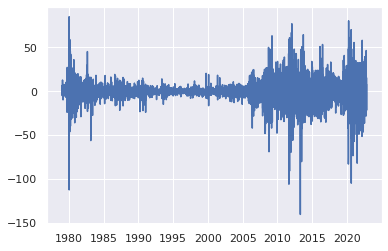

ADF Statistic: -17.620538
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [107]:
# To remove trends, differencing of order 1
k = data_gold['US dollar'].diff()
plt.plot(data_gold.index, k)
plt.show()
k = k.dropna()

# Check stationarity after differencing
result_of_adfuller = adfuller(k)
print('ADF Statistic: %f' % result_of_adfuller[0])
print('p-value: %f' % result_of_adfuller[1])
print('Critical Values:')
for key, value in result_of_adfuller[4].items():
    print('\t%s: %.3f' % (key, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

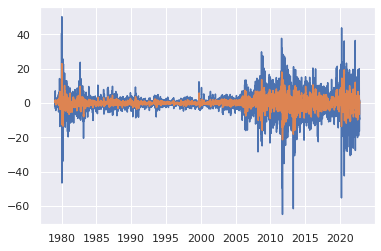

Gold Price = -0.01 * 2 Month Moving Average -0.06 * 1 Month Moving Average + 0.12


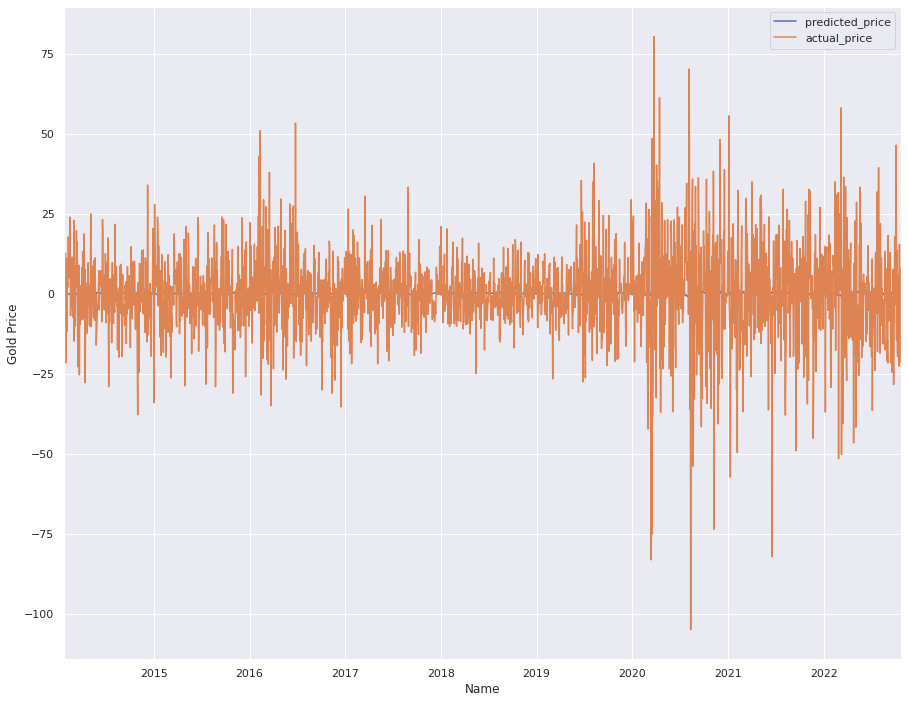

R square for regression 0.03


13.310096116166307

In [108]:
# Again regression
data_gold['US dollar'] = k

# Finding moving average of past 3 days and 12 days
data_gold['S_1'] = data_gold['US dollar'].shift(1).rolling(window=3).mean()
data_gold['S_2'] = data_gold['US dollar'].shift(1).rolling(window=12).mean()
data_gold = data_gold.dropna()
X = data_gold[['S_1', 'S_2']]

plt.plot(data_gold.index, data_gold['S_1'])
plt.plot(data_gold.index, data_gold["S_2"])
plt.show()

data_gold['S_1'] = data_gold['US dollar'].shift(1).rolling(window=3).mean()
data_gold['S_2'] = data_gold['US dollar'].shift(1).rolling(window=12).mean()

# Dependent variable
y = data_gold['US dollar']

# Split into train and test
t = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t, shuffle=False)

# Performing linear regression
linear = LinearRegression().fit(X_train, y_train)

print("Gold Price =", round(linear.coef_[0], 2), "* 2 Month Moving Average", round(
    linear.coef_[1], 2), "* 1 Month Moving Average +", round(linear.intercept_, 2))

# Predict prices
predicted_price = linear.predict(X_test)

predicted_price = pd.DataFrame(predicted_price, index=y_test.index, columns=['price'])
predicted_price.plot(figsize=(15, 12))
y_test.plot()
plt.legend(['predicted_price', 'actual_price'])
plt.ylabel("Gold Price")
plt.show()

# Calculate R square and rmse to check goodness of fit
r2_score = linear.score(X_test, y_test)*100
print("R square for regression", float("{0:.2f}".format(r2_score)))
sqrt(mean_squared_error(y_test,predicted_price))

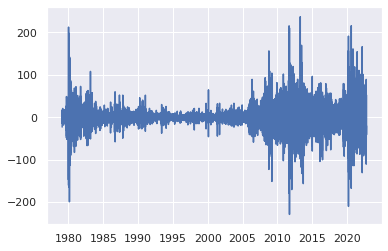

ADF Statistic: -37.347882
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [109]:
# Trying 2nd order differencing
k = data_gold['US dollar'].diff().diff()
plt.plot(data_gold.index, k)
plt.show()
k = k.dropna()

# Check stationarity after differencing
result_of_adfuller = adfuller(k)
print('ADF Statistic: %f' % result_of_adfuller[0])
print('p-value: %f' % result_of_adfuller[1])
print('Critical Values:')
for key, value in result_of_adfuller[4].items():
    print('\t%s: %.3f' % (key, value))

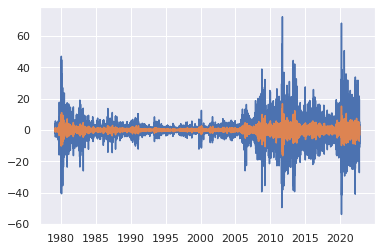

Gold Price = -1.4 * 2 Month Moving Average -6.49 * 1 Month Moving Average + 0.0


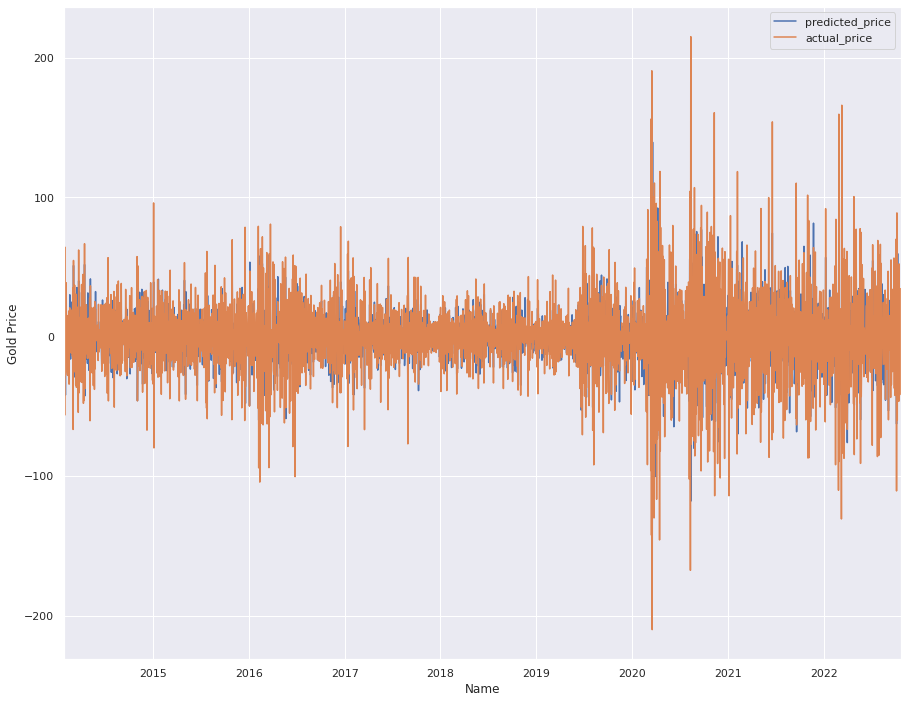

R square for regression 48.88
RMSE:  23.725054418599264


In [110]:
# Again regression
data_gold['US dollar'] = k

# Finding moving average of past 3 days and 12 days
data_gold['S_1'] = data_gold['US dollar'].shift(1).rolling(window=3).mean()
data_gold['S_2'] = data_gold['US dollar'].shift(1).rolling(window=12).mean()
data_gold = data_gold.dropna()
X = data_gold[['S_1', 'S_2']]

plt.plot(data_gold.index, data_gold['S_1'])
plt.plot(data_gold.index, data_gold["S_2"])
plt.show()

# Dependent variable
y = data_gold['US dollar']

data_gold['S_1'] = data_gold['US dollar'].shift(1).rolling(window=3).mean()
data_gold['S_2'] = data_gold['US dollar'].shift(1).rolling(window=12).mean()

# Split into train and test
t = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t, shuffle=False)

# Performing linear regression
linear = LinearRegression().fit(X_train, y_train)

print("Gold Price =", round(linear.coef_[0], 2), "* 2 Month Moving Average", round(
    linear.coef_[1], 2), "* 1 Month Moving Average +", round(linear.intercept_, 2))

# Predict prices
predicted_price = linear.predict(X_test)

predicted_price = pd.DataFrame(
    predicted_price, index=y_test.index, columns=['price'])
predicted_price.plot(figsize=(15, 12))
y_test.plot()
plt.legend(['predicted_price', 'actual_price'])
plt.ylabel("Gold Price")
plt.show()

# Calculate R square and rmse to check goodness of fit
r2_score = linear.score(X_test, y_test)*100
print("R square for regression", float("{0:.2f}".format(r2_score)))
print("RMSE: ",sqrt(mean_squared_error(y_test,predicted_price)))

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


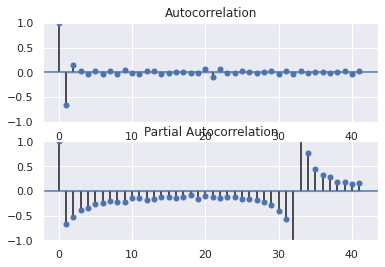

In [111]:
# After 2nd order differencing the results make sense, but are still unacceptably innacurate.
# Try to make an ARMA model with the new non-stationary data. 

# ACF and PACF plots
series = data_gold['US dollar']
plt.figure()
plt.subplot(211)
plot_acf(series, ax=plt.gca())
plt.subplot(212)
plot_pacf(series, ax=plt.gca())
plt.show()

In [112]:
# From statsmodels.tsa.statespace import SARIMAX
model = SARIMAX(data_gold['US dollar'].values, order=(2, 1, 2), seasonal_order=(0, 0, 0, 0), enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                11392
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -45170.316
Date:                Thu, 27 Oct 2022   AIC                          90350.631
Time:                        23:30:41   BIC                          90387.333
Sample:                             0   HQIC                         90362.975
                              - 11392                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6948      0.010    -72.589      0.000      -0.714      -0.676
ar.L2         -0.3815      0.009    -42.924      0.000      -0.399      -0.364
ma.L1         -1.9996      0.007   -281.542      0.000      -2.014      -1.986
ma.L2          0.9997      0.007    139.290      0.000       0.986       1.014
sigma2       278.1521      3.314     83.925      0.000     271.656     284.648
===================================================================================
Ljung-Box (L1) (Q):                  66.71   Jarque-Bera (JB):            116452.41
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.47   Skew:                            -0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

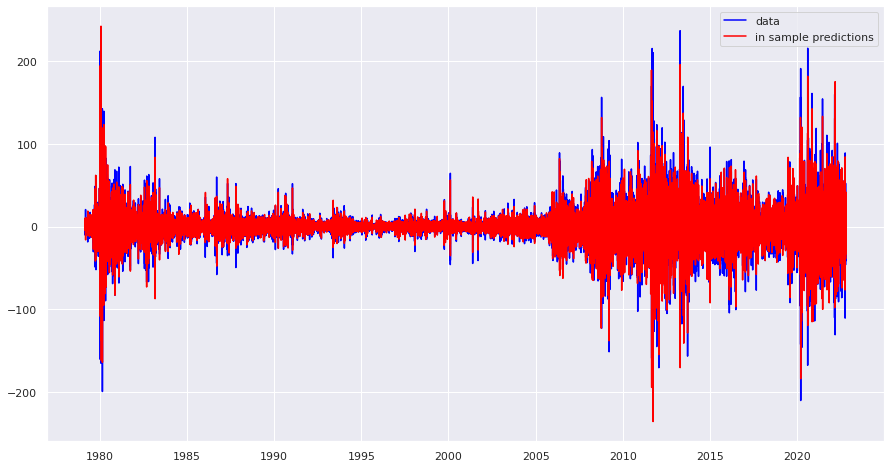

In [113]:
data_gold['sarimax_predict'] = results.predict()

fig,ax = plt.subplots(figsize=(15,8))
plt.plot(data_gold.index, data_gold['US dollar'], label='data', color='blue')
plt.plot(data_gold.index, data_gold["sarimax_predict"], label='in sample predictions', color='red')
plt.legend()
plt.show()

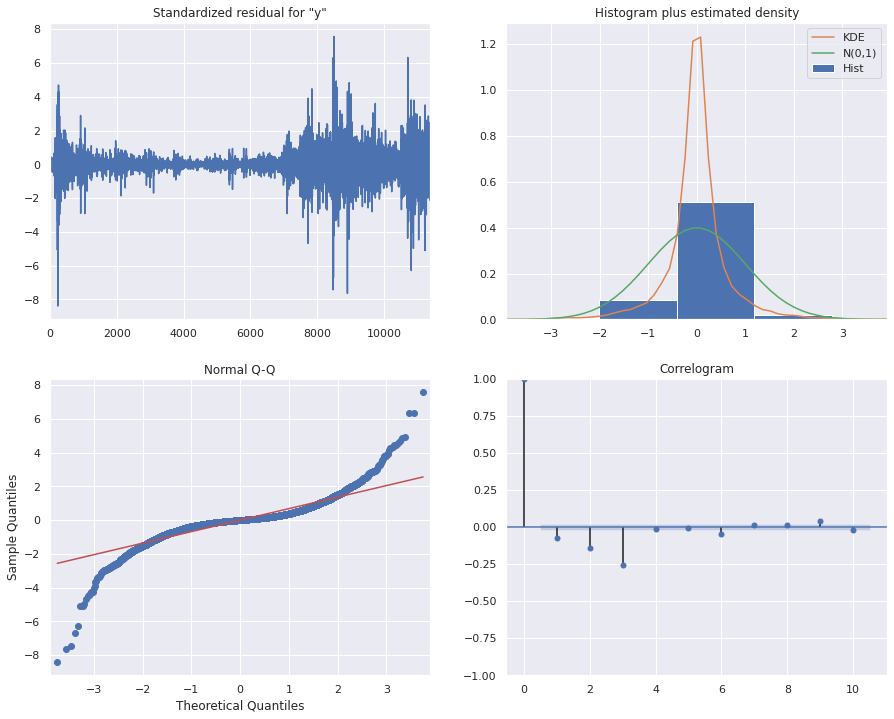

In [114]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

### R2 - Coeficiente de determinación 

In [118]:
from sklearn.metrics import r2_score
print("RMSE:", sqrt(mean_squared_error(data_gold['US dollar'], data_gold['sarimax_predict'])))
print("R2 SCORE:", r2_score(data_gold['US dollar'], data_gold['sarimax_predict']))

RMSE: 11.378600310270047
R2 SCORE: 0.7825972147630706
